In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as stats
import tensorflow as tf
import os


/home/eric/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
slim = tf.contrib.slim
Exponential = tf.contrib.distributions.Exponential(rate = 1.0)     # exp(1)
Normal1 = tf.contrib.distributions.Normal(loc = -2.0, scale = 1.0) # N(-2, 1)
Normal2 = tf.contrib.distributions.Normal(loc = 2.0, scale = 1.0)  # N( 2, 1)
Normal = tf.contrib.distributions.Normal(loc = 0., scale = 1.0)    # N( 0, 1)

directory = os.getcwd()

In [3]:
def sample_n(mu, sigma):
    eps = tf.random_normal(shape = tf.shape(mu)) # sample random noise ~ N(0, 1)
    z = mu + eps * sigma
    return z


def sample_hyper(noise_dim,K,reuse=False): 
    z_dim = 1
    with tf.variable_scope("hyper_q") as scope:
        if reuse:
            scope.reuse_variables()
        e2 = tf.random_normal(shape=[K,noise_dim])
        input_ = e2
        h2 = slim.stack(input_,slim.fully_connected,[20,40,20])
        mu = tf.reshape(slim.fully_connected(h2, z_dim, activation_fn = None, 
                                             scope = 'implicit_hyper_mu'), [-1,1])
    return mu

In [4]:
data_p = {"1":"gaussian","2":"laplace","3":"gmm"}
data_number = "3"
target = data_p[data_number] 
   
#%%
noise_dim = 10
K = 20 

psi_sample = sample_hyper(noise_dim,K)

sigma = tf.constant(0.2)
z_sample = sample_n(psi_sample,sigma) 


J = tf.placeholder(tf.int32, shape=()) 
psi_star = tf.transpose(sample_hyper(noise_dim,J,reuse=True)) 

merge = tf.placeholder(tf.int32, shape=[])
psi_star = tf.cond(merge>0,
                   lambda:tf.concat([psi_star,tf.transpose(psi_sample)],1),
                   lambda:psi_star)


log_H= tf.log(tf.reduce_mean(tf.exp(-0.5*tf.square(z_sample-psi_star)/tf.square(sigma)),
                             axis=1,keep_dims=True))

#log_Q = -tf.log(sigma)-0.5*tf.square(z_sample-psi_sample)/tf.square(sigma)
#regular = log_Q - log_H

if target == 'gaussian':
    log_P = -tf.log(3.0)-0.5*tf.square(z_sample)/tf.square(3.0) #gaussian
elif target == 'laplace':
    log_P = -0.5*tf.abs(z_sample) #laplace(mu=0,b=2)
elif target == 'gmm': # gaussian mixture
    log_P =tf.log(0.3*tf.exp(-tf.square(z_sample+2)/2) + \
                  0.7*tf.exp(-tf.square(z_sample-2)/2))
else:
    raise ValueError('No pre-defined target distribution, you can write your own log(PDF) ')
    
loss = tf.reduce_mean(log_H - log_P)

nn_var =  slim.get_model_variables()
lr=tf.constant(0.01)
train_op1 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,var_list=nn_var)

init_op=tf.global_variables_initializer()


#%%
# merge == 1 corresponds to lower bound; merge==0 corresponds to upper bound
sess=tf.InteractiveSession()
sess.run(init_op)
record = []
for i in range(5000):
    _,cost=sess.run([train_op1,loss],{lr:0.01*(0.75**(i/100)),J:100,merge:1})
    record.append(cost)
    if i%500 == 0:
        print("iter:", '%04d' % (i+1), "cost=", np.mean(record))
        record = []
#%% plot Q and target
r_hive=[]
for i in range(100):
    r = sess.run(z_sample)
    r_hive.extend(np.squeeze(r))

yy=[]
xx = np.arange(-10,10,0.01)
for r in xx:
    if target=='gaussian':
        pdf = stats.norm.pdf(r, loc=0, scale=3) #gaussian
    elif target=='laplace':
        pdf = 1/4*np.exp(-0.5*np.abs(r)) #laplace
    elif target=='gmm':
        pdf = 0.3*stats.norm.pdf(r, loc=-2, scale=1) + \
                0.7*stats.norm.pdf(r, loc=2, scale=1) #gmm
    yy.append(pdf)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
iter: 0001 cost= 0.6787469
iter: 0501 cost= -1.4907397
iter: 1001 cost= -1.542794
iter: 1501 cost= -1.5502045
iter: 2001 cost= -1.5512751
iter: 2501 cost= -1.546396
iter: 3001 cost= -1.5428218
iter: 3501 cost= -1.553041
iter: 4001 cost= -1.5402932
iter: 4501 cost= -1.5473591


/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


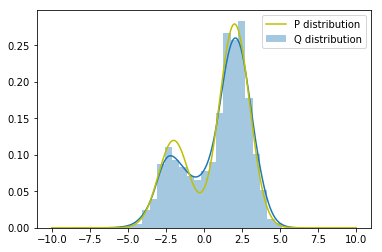

In [5]:
ax=plt.figure()
ax=sns.distplot(r_hive,label='Q distribution')
ax=plt.plot(xx,yy,'y-',label='P distribution')
plt.legend()

/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Gaussian \\mu_i')

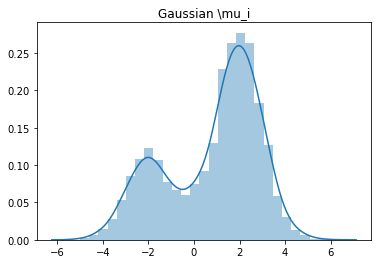

In [6]:
#%% plot latent
latent=[]
for i in range(200):
    muu = sess.run(psi_sample)
    latent.extend(np.squeeze(muu))
plt.figure()
sns.distplot(latent)
plt.title("Gaussian \mu_i")